In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def f(x):
    return 3*x**2 - 4*x + 5

In [5]:
f(3.0)

20.0

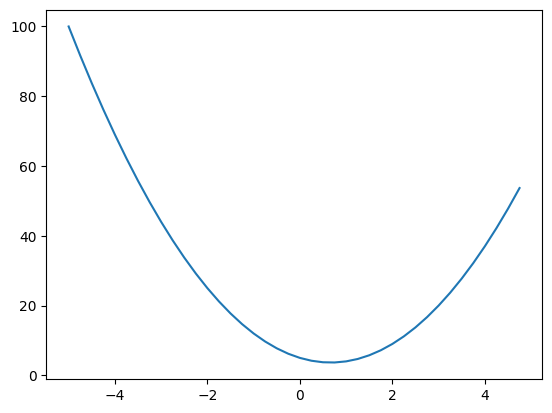

In [7]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [13]:
h = 0.000000000001
x = 3.0
( f(x + h) - f(x) ) / h

14.001244608152774

In [144]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 #the gradient with respect to the final value
        self._backward = lambda: None
        self._prev = set(_children) #_children is a tuple and contains all the expressions when used in operations
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) #type coercing

        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other) #type coercing

        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += 1.0 * other.data * out.grad
            other.grad += 1.0 * self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self*other #rmul is the back multiplication. allows us to do int*Value()
    
    def __radd__(self, other):
        return self+other #radd is the backup addition. allows us to do int+Value()
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only int/float"
        out = Value(self.data**other, (self, ), f'**{other}')
        def _backward():
            self.grad += other * self.data ** (other -1) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def backward(self):
        #Laid out the mathematical expression and going backwards; we have to do everything after it before we call the _backward() on it
        # We do this through topological sorting: only go from L -> R
        topo = []

        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        #only adds you in thel list once children are in visited. ensures topological sorting

        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
                


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [45]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #left-right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))

        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad, ), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid+n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [50]:
# Manual backprop
L.grad = 1.0

In [52]:
f.grad = 4.0
d.grad = -2.0

In [54]:
# a + node's local derivatives are just 1 so a + routes the output derivative to the input variables
c.grad = -2.0
e.grad = -2.0

# for a more indepth, look at the CHAIN rule

In [58]:
# dL/de = -2.0
# dL / da = (dL / de) * (de / da) = -2.0*b  = -6.0
a.grad = 6.0

b.grad = -4.0
#multiplication takes local derivatives and multiplies by input derivative

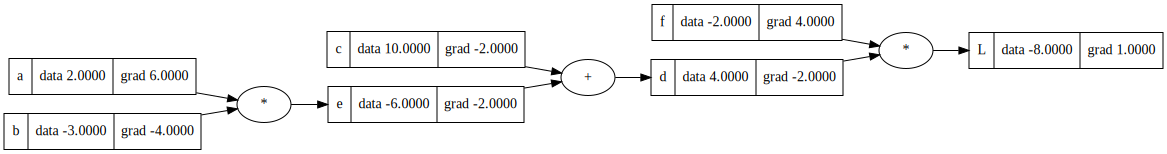

In [59]:
draw_dot(L)

In [60]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
d.data += 0.01 * f.grad
e = a * b
d = e + c
L = d * f
print(L.data)

-7.4352


In [49]:
def localTest():
    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data + h

    print((L2-L1)/h)

localTest()

1.000000000000334


# Backpropagation in Neuron

In [127]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

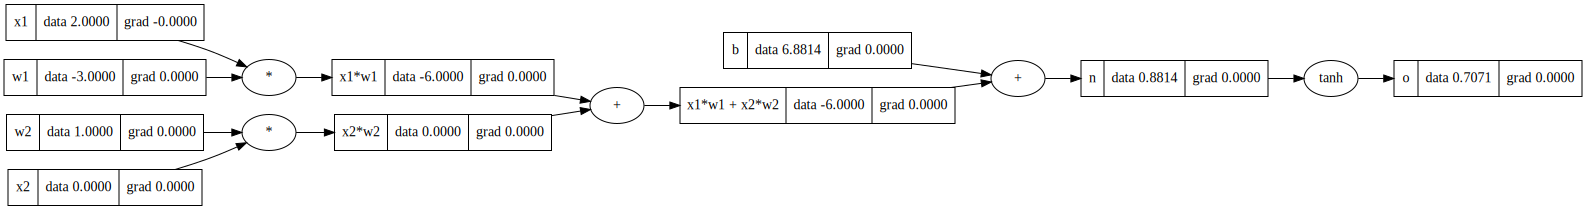

In [84]:
draw_dot(o)

In [70]:
#back propagation of neuron
o.grad = 1.0

In [72]:
#backpropagation through tanh
# o = tanh(n)
# do/dn = 1 - o**2
# n.grad = 1 - (o.data**2)
n.grad = 0.5

In [76]:
# + is router of derivatves
x1w1x2w2.grad = 0.5
b.grad = 0.5
x2w2.grad = 0.5
x1w1.grad = 0.5

In [80]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

Implement backpropagation automatically

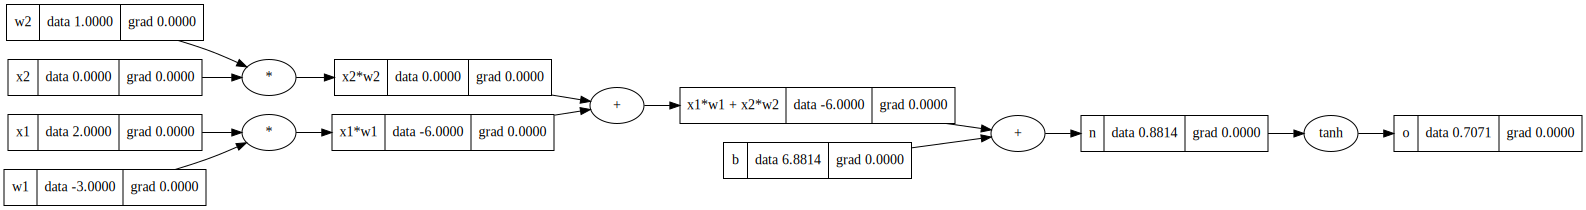

In [98]:
draw_dot(o) #after reinitializing o

In [99]:
#base case
o.grad = 1.0

o._backward() #backpropagates derivative

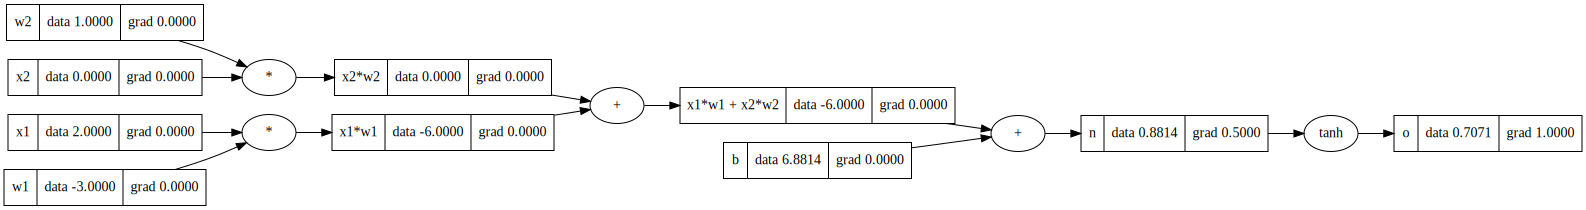

In [100]:
draw_dot(o)

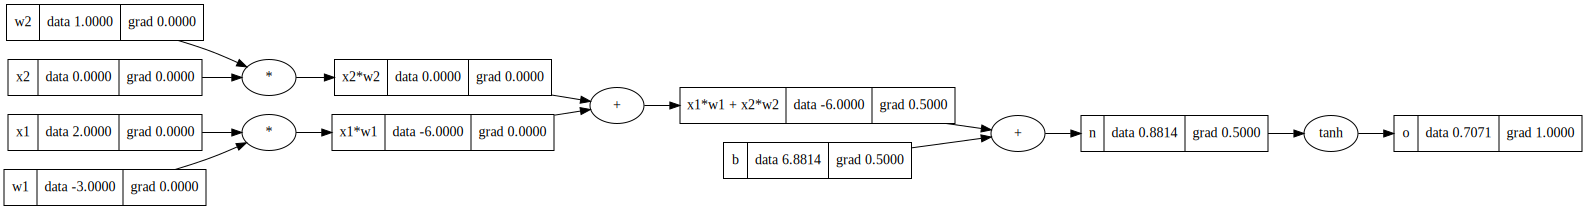

In [101]:
n._backward()
draw_dot(o)

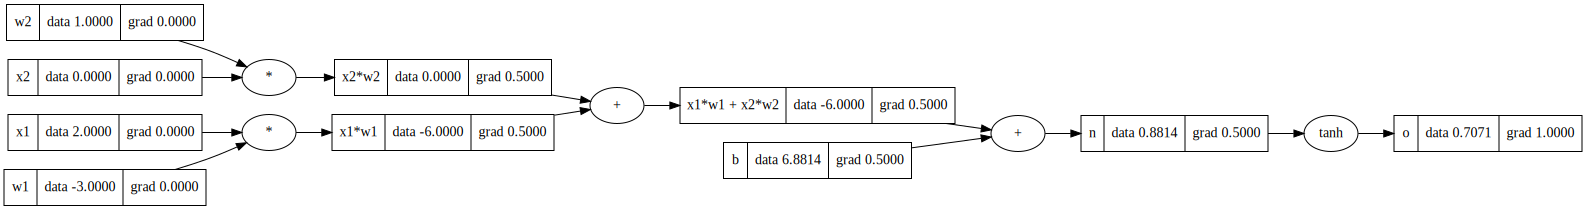

In [102]:
b._backward()
x1w1x2w2._backward()
draw_dot(o)

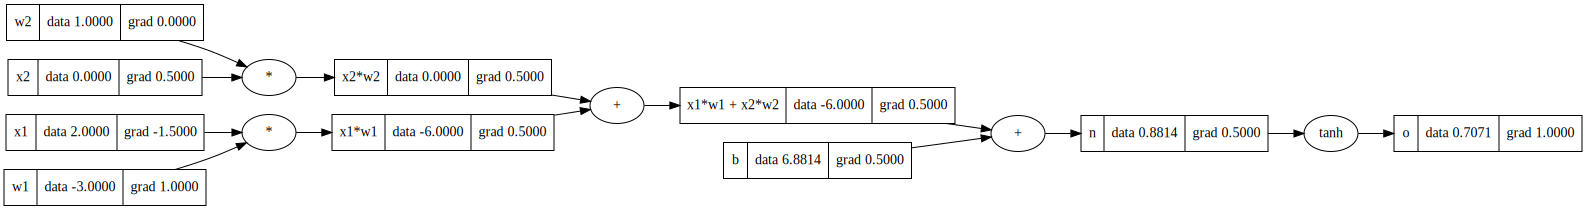

In [103]:
x1w1._backward()
x2w2._backward()
draw_dot(o)

In [104]:
#Laid out the mathematical expression and going backwards; we have to do everything after it before we call the _backward() on it
# We do this through topological sorting: only go from L -> R
topo = []

visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

#only adds you in thel list once children are in visited. ensures topological sorting

build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

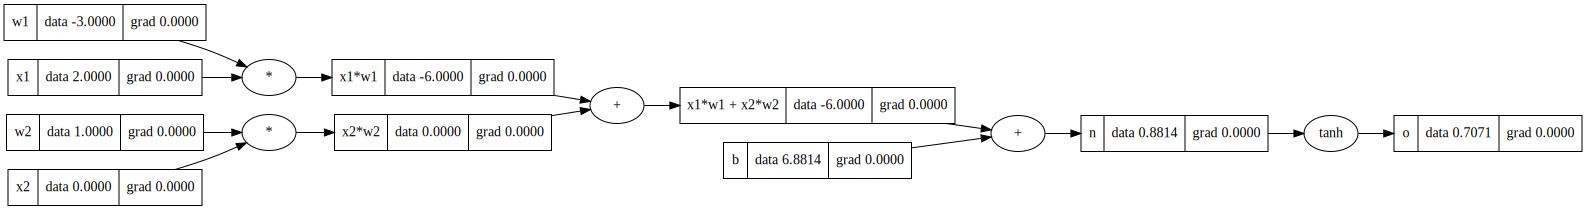

In [106]:
draw_dot(o)

In [107]:
#Fully automated

o.grad = 1.0

#Laid out the mathematical expression and going backwards; we have to do everything after it before we call the _backward() on it
# We do this through topological sorting: only go from L -> R
topo = []

visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

#only adds you in thel list once children are in visited. ensures topological sorting

build_topo(o)

for node in reversed(topo):
    node._backward()

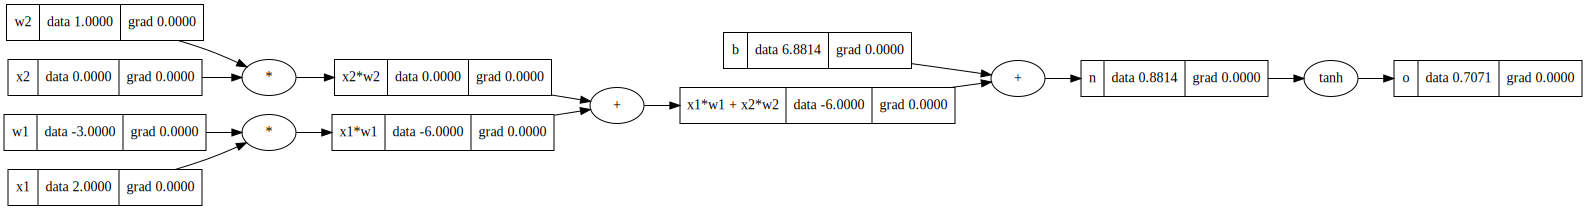

In [129]:
#Now fully automated in Value
draw_dot(o)

In [130]:
o.backward()

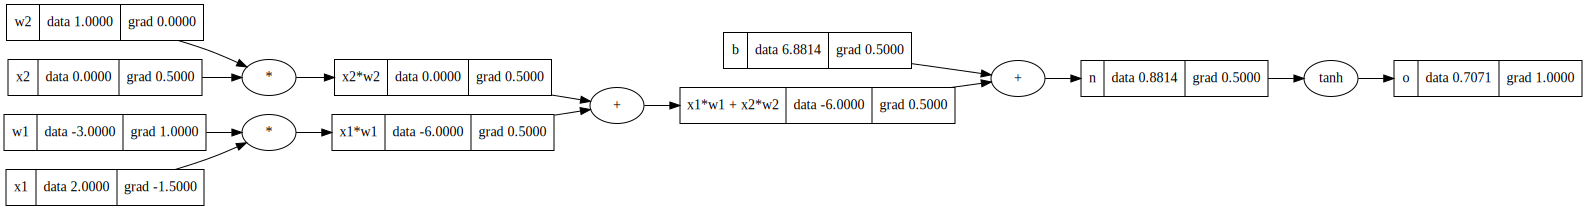

In [131]:
draw_dot(o)

Bugs in Backprop

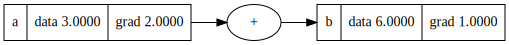

In [124]:
a = Value(3.0, label='a')
b = a+a; b.label ='b'
b.backward()
draw_dot(b)

#derivative of a is wrong. it should be 2 since a+a => 2a => 2.

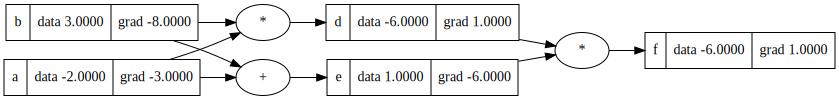

In [125]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')

d = a*b; d.label = 'd'
e = a+b; e.label ='e'
f = d*e; f.label='f'

f.backward()

draw_dot(f)

#the problem is that multiple variable usage overrides derivatives
#fix = add the derivatives from multiple expressions

# Breaking up Tanh with more operations

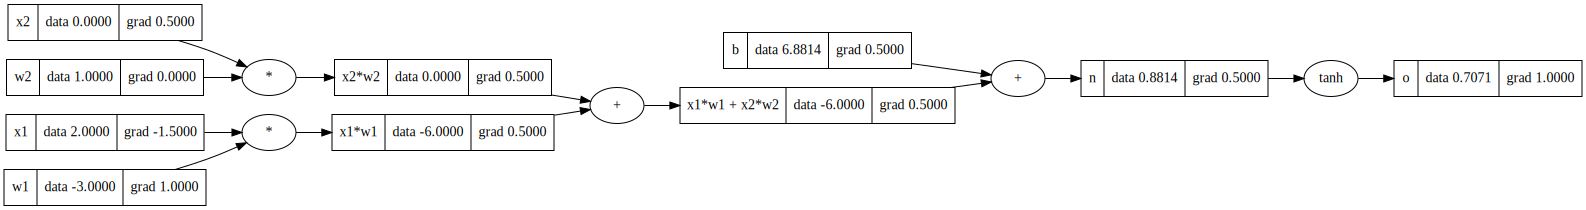

In [135]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()
draw_dot(o)

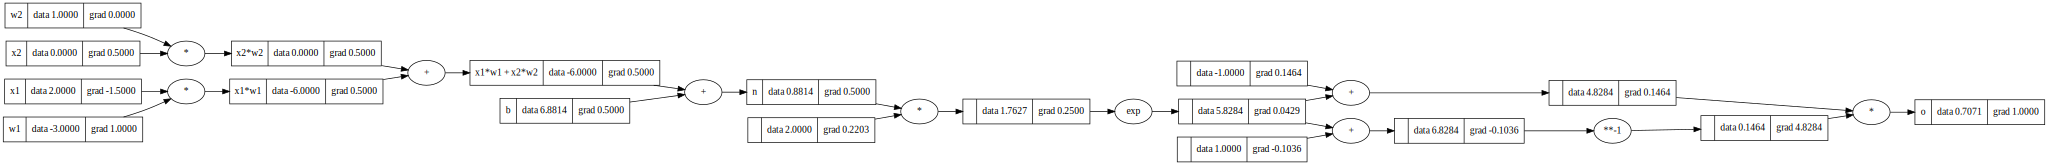

In [136]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp()
o = (e-1) / (e+1); o.label='o'
o.backward()
draw_dot(o)

# Doing the same thing in PyTorch

In [138]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True #Tensors = n-dimensional arrays of scalars ; 
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True

w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True

n = x1*w1 + x2*w2 + b

o = torch.tanh(n)

print(o.data.item())
o.backward()


print('---------')

print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


# Building out Neural Net

In [151]:
import random


class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range (nin)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self, x):
        #w * x + b
        act = sum((wi*xi for wi, xi, in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        print(sz)
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

[3, 4, 4, 1]


Value(data=0.7948476604375457)

In [152]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=0.7948476604375457),
 Value(data=0.4564410529411813),
 Value(data=0.3658558371432396),
 Value(data=0.6992701702580918)]

In [155]:
#single number that measures perf of neural net => LOSS
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
print(loss)

Value(data=4.119308621475223)


In [156]:
loss.backward()

In [158]:
n.layers[0].neurons[0].w[0].grad #grad = negative and increasing this weight will make the loss go down.

-2.1319923906346747

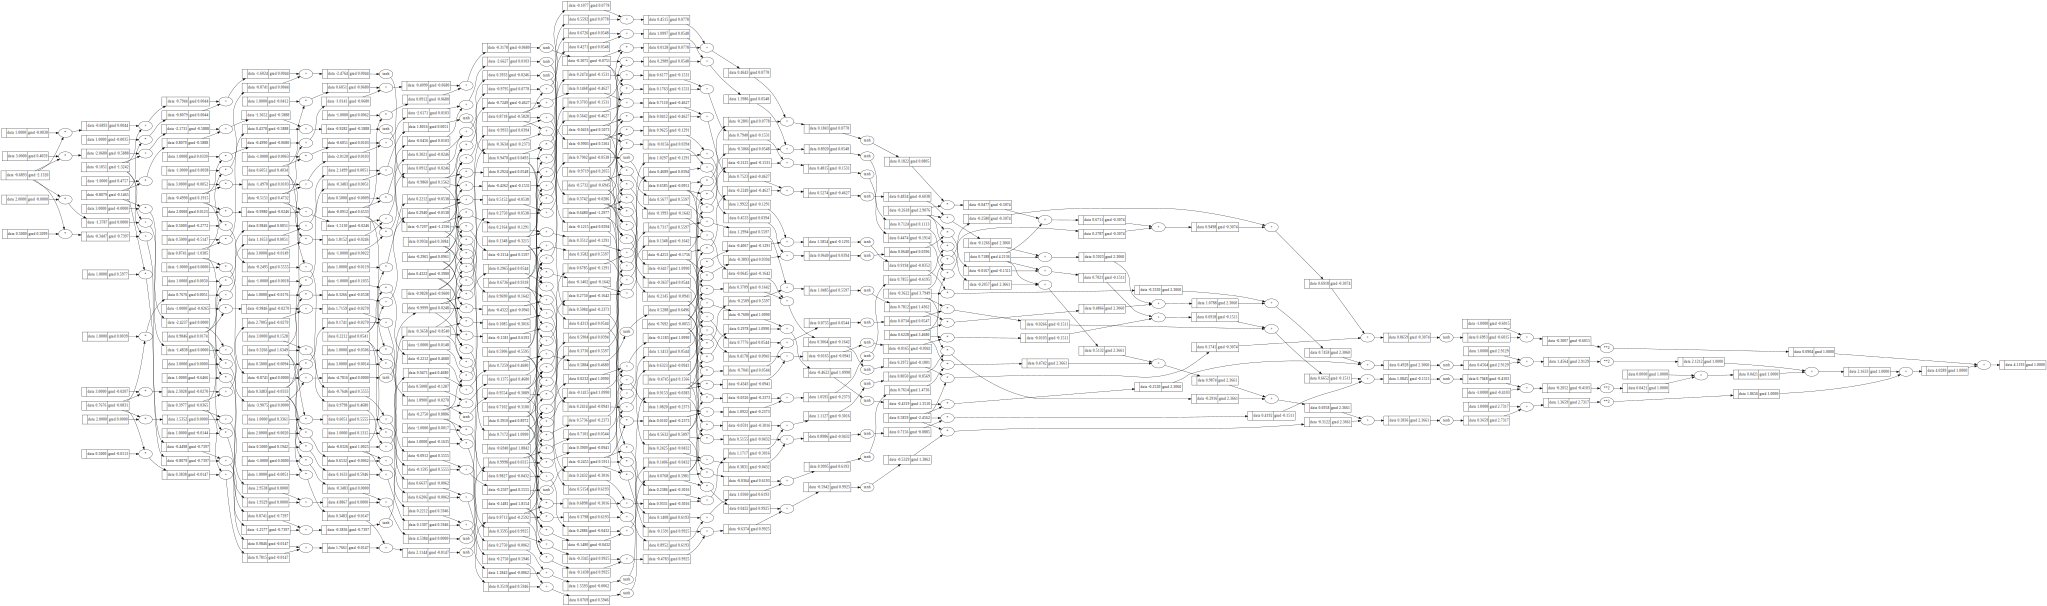

In [159]:
draw_dot(loss)